## Introduction 
#### what is a neural network?
 A neural Network is a computational model inspired by the human brain. Each neuron recieves an activation signal from the preceeding layer and computes some value that is propoagated forward
 #### Key Concepts:
 - **Input Layer**: Receives the raw input data (e.g., pixel values from an image).
 - **Hidden Layers**: Perform computations to extract meaningful features.
 - **Output Layer**: Produces the final predictions (e.g., the digit class).

 #### Activation Functions:
 Activation functions (e.g., ReLU, sigmoid) introduce non-linearity into the model, enabling it to learn complex patterns.

 #### Loss Function:
 The loss function measures the error between the predicted outputs and the true labels. In this task, we'll use Cross Entropy Loss, which is commonly used for classification problems.

 #### Optimization:
 The optimizer (e.g., Stochastic Gradient Descent) updates the network's weights to minimize the loss function during training.

 #### Problem Statement:
 In this assignment, we will use the MNIST dataset to train a neural network to classify handwritten digits (0-9). We'll explore various hyperparameters, analyze their effects, and optionally use advanced techniques such as convolutional layers and dropout.

## 1 Data Processing
 before we attempt to train our model we must make sure that our data conforms with required criteria:
 - the samples are tensors
 - 60 % training , 20 % validation , 20 % test 
 - keep a "straigtified" manner to avoid data skewing

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
from torchvision import datasets, transforms
from torch.utils.data import DataLoader,Subset,ConcatDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

In [23]:

# Apply transformations (convert to tensor and normalize)
transform = transforms.Compose([
    transforms.ToTensor(), #convert vector values in range [0,1]
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1] range (z socre)
])

# Load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform) #this structure contains data and labels
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

#combine the datasets
combined_dataset=ConcatDataset([train_dataset,test_dataset])

#extract labels
train_labels=train_dataset.targets
test_labels=test_dataset.targets

# Combine labels from both train and test datasets
all_labels = torch.cat((train_labels, test_labels), dim=0)

#split into 60-40 
train_idx, temp_idx = train_test_split(
    range(len(combined_dataset)), test_size=0.4, stratify=all_labels, random_state=42) # stratify 3lshan not to get skewed data


#split again 20-20
# Split temp (40%) into validation (20%) and test (20%)
val_idx, test_idx = train_test_split(
    temp_idx, test_size=0.5, stratify=all_labels[temp_idx], random_state=42) # returns indices 


# Create Subset objects for train, validation, and test sets
train_data = Subset(combined_dataset, train_idx)
val_data = Subset(combined_dataset, val_idx)
test_data = Subset(combined_dataset, test_idx) 


##recreate dataset w inheirt combatible structure with data loader
# Create DataLoader objects
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Print split sizes
print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")
print("Data preparation complete!")



Training set size: 42000
Validation set size: 14000
Test set size: 14000
Data preparation complete!


 now we build our neural network architecture. we will start with a basic model containing a single hidden layer.

In [14]:
# 2 create neural network structure
class Neural_Network_1_hidden_layer(nn.Module):
        def __init__(self, input_size=28*28, hidden_size=10, num_classes=10):
            super(Neural_Network_1_hidden_layer, self).__init__()
            self.fc1 = nn.Linear(input_size, hidden_size) 
            self.fc2 = nn.Linear(hidden_size, num_classes)

        def forward(self, x):
            x = x.view(-1, 28*28)  # Flatten the input
            x = torch.relu(self.fc1(x))  # Apply ReLU activation after first hidden layer
            x = self.fc2(x)  # Output layer
            return x

 before we start the training process we need to make sure that we are using GPU accelerated training 

In [15]:

# 3. Set device to GPU if available, else fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the model and move it to the selected device
model = Neural_Network_1_hidden_layer().to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)


 we will now proceed to train our model for 10 epochs where each epoch consists of a training phase followed by a vildation phase.

In [24]:

# 4. Training Process
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0 # this is the cumulative loss during epoch
        correct_train = 0  
        total_train = 0
        
        # Train the model on the training set
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Move to GPU
            
            optimizer.zero_grad()
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass (compute gradients)
            optimizer.step()  # Update weights

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)  # Get the predicted class
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train * 100
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)  # Move to GPU
                outputs = model(images)  # Forward pass
                loss = criterion(outputs, labels)

                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        avg_val_loss = running_loss / len(val_loader)
        val_accuracy = correct_val / total_val * 100
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    
    return train_losses, val_losses, train_accuracies, val_accuracies


In [25]:
# Train the model
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=10
)


Epoch [1/10], Train Loss: 0.7482, Train Accuracy: 79.45%, Validation Loss: 0.4044, Validation Accuracy: 88.41%
Epoch [2/10], Train Loss: 0.3660, Train Accuracy: 89.56%, Validation Loss: 0.3581, Validation Accuracy: 89.84%
Epoch [3/10], Train Loss: 0.3296, Train Accuracy: 90.50%, Validation Loss: 0.3440, Validation Accuracy: 90.03%
Epoch [4/10], Train Loss: 0.3111, Train Accuracy: 91.06%, Validation Loss: 0.3429, Validation Accuracy: 90.07%
Epoch [5/10], Train Loss: 0.2971, Train Accuracy: 91.52%, Validation Loss: 0.3994, Validation Accuracy: 87.59%
Epoch [6/10], Train Loss: 0.2860, Train Accuracy: 91.93%, Validation Loss: 0.3136, Validation Accuracy: 90.84%
Epoch [7/10], Train Loss: 0.2774, Train Accuracy: 92.08%, Validation Loss: 0.2960, Validation Accuracy: 91.43%
Epoch [8/10], Train Loss: 0.2704, Train Accuracy: 92.21%, Validation Loss: 0.2918, Validation Accuracy: 91.71%
Epoch [9/10], Train Loss: 0.2648, Train Accuracy: 92.42%, Validation Loss: 0.2877, Validation Accuracy: 91.74%
E

 now we plot the performance of our simple model

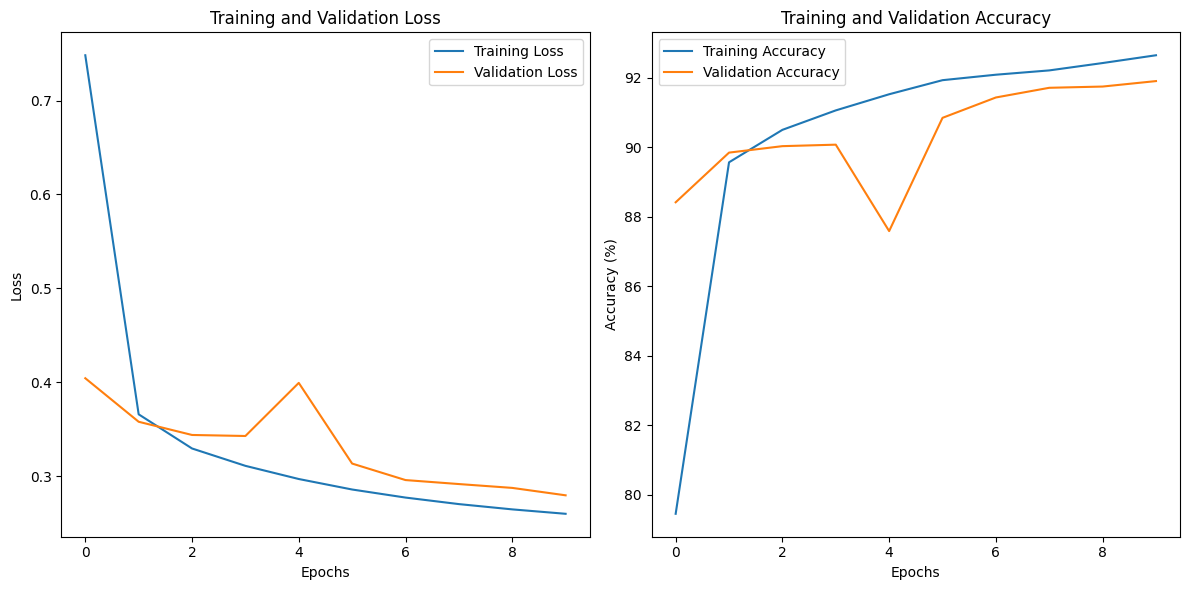

In [26]:
# 5. Plot Training and Validation Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 6. Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

## part 2
 for this part we will attempt to tune the model parameters by tweaking a single paramter(the others remain constant) and retraining the model and then comparing results we will use the following paramters:
 
 - number of hiddden layers =[1,3,5,7]
 - number of neurons per hidden layer= [10,20,30,40]
 - batch size for stochastic gradient descent= [32,64,128,256]
 - learning rate =[0.10.01,0.001,0.0001]

 in total, we train the model for a total of 16 times.

 Total iterations:
    6+6+6+6=24

 we will create a function the iterates over the said parameters but fristly we define our parameter ranges in a dictionary.

In [27]:
# Hyperparameters for tuning
default_params = {
    "hidden_layers": 1,  # Number of hidden layers
    "hidden_size": 10,   # Number of neurons per hidden layer
    "batch_size": 32,    # Batch size for SGD
    "learning_rate": 0.01  # Learning rate
}

# Define the ranges for each hyperparameter
param_ranges = {
    "hidden_layers": [1, 3, 5, 7,9,11],
    "hidden_size": [10, 20, 30, 40, 50 , 60],
    "batch_size": [32, 64, 128, 256,500, 1000 ],
    "learning_rate": [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
}

then we proceed to create a neural network class with a variable layer size

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    y_true, y_pred = [], []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Move to GPU/CPU
            optimizer.zero_grad() # remove gradients to prevent gradient accumulatioin
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() # add current batch loss
            _, predicted = torch.max(outputs, 1) # index of max probability
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)# keep track of all samples trained

        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train * 100
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)
                y_true.extend(labels.cpu().numpy()) ##move to cpu for transforming into numpy array 
                y_pred.extend(predicted.cpu().numpy())

        avg_val_loss = running_loss / len(val_loader)
        val_accuracy = correct_val / total_val * 100
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    
    # Return all six variables
    return train_losses, val_losses, train_accuracies, val_accuracies, y_true, y_pred


In [29]:
# Function to build a model with variable hidden layers
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_layers, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        layers = []
        for i in range(hidden_layers):
            if i == 0:
                layers.append(nn.Linear(input_size, hidden_size)) # for inout layer
            else:
                layers.append(nn.Linear(hidden_size, hidden_size)) ##every layer in between
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_size, num_classes))  # Final output layer
        self.network = nn.Sequential(*layers) ##link layers

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten input
        return self.network(x)

 a function that iterares over parameter values

In [30]:
# Hyperparameter tuning function
def tune_hyperparameters(default_params, param_ranges, num_epochs=10):
    results = []
    
    # Iterate over each parameter
    for param, values in param_ranges.items():
        for value in values:
            # Update the parameter value
            params = default_params.copy()
            params[param] = value
            
            # Update DataLoader if batch_size changes
            batch_size = params["batch_size"]
            train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

            # Build the model
            model = NeuralNetwork(
                input_size=28 * 28,
                hidden_layers=params["hidden_layers"],
                hidden_size=params["hidden_size"],
                num_classes=10
            ).to(device)
            
            # Define optimizer with new learning rate
            optimizer = optim.SGD(model.parameters(), lr=params["learning_rate"])
            criterion = nn.CrossEntropyLoss()
            
            # Train the model
            train_losses, val_losses, train_accuracies, val_accuracies, y_true, y_pred = train_model(
                model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs
            )
            
            # Record results
            results.append({
                "param": param,
                "value": value,
                "train_accuracy": train_accuracies[-1],
                "val_accuracy": val_accuracies[-1],
                "train_loss": train_losses[-1],
                "val_loss": val_losses[-1],
                "y_true": y_true,
                "y_pred": y_pred
            })
            
            print(f"Completed training for {param} = {value}")
    
    return results

In [31]:
results = tune_hyperparameters(default_params, param_ranges)

Epoch [1/10], Train Loss: 0.7375, Train Accuracy: 78.66%, Validation Loss: 0.4049, Validation Accuracy: 88.85%
Epoch [2/10], Train Loss: 0.3615, Train Accuracy: 89.62%, Validation Loss: 0.3425, Validation Accuracy: 90.00%
Epoch [3/10], Train Loss: 0.3255, Train Accuracy: 90.47%, Validation Loss: 0.3280, Validation Accuracy: 90.59%
Epoch [4/10], Train Loss: 0.3084, Train Accuracy: 91.12%, Validation Loss: 0.3418, Validation Accuracy: 90.21%
Epoch [5/10], Train Loss: 0.2994, Train Accuracy: 91.34%, Validation Loss: 0.3279, Validation Accuracy: 90.37%
Epoch [6/10], Train Loss: 0.2913, Train Accuracy: 91.56%, Validation Loss: 0.3195, Validation Accuracy: 90.84%
Epoch [7/10], Train Loss: 0.2862, Train Accuracy: 91.77%, Validation Loss: 0.3006, Validation Accuracy: 91.45%
Epoch [8/10], Train Loss: 0.2806, Train Accuracy: 92.00%, Validation Loss: 0.3118, Validation Accuracy: 91.15%
Epoch [9/10], Train Loss: 0.2762, Train Accuracy: 92.06%, Validation Loss: 0.2992, Validation Accuracy: 91.62%
E

In [32]:
import pandas as pd

# Convert the results list to a DataFrame
df = pd.DataFrame(results)

# Inspect the columns to ensure they match expected names
print("Columns in DataFrame:", df.columns)

# Verify sample rows to confirm data integrity
print(df.head())


Columns in DataFrame: Index(['param', 'value', 'train_accuracy', 'val_accuracy', 'train_loss',
       'val_loss', 'y_true', 'y_pred'],
      dtype='object')
           param  value  train_accuracy  val_accuracy  train_loss  val_loss  \
0  hidden_layers    1.0       92.130952     91.135714    0.272497  0.306914   
1  hidden_layers    3.0       92.021429     89.721429    0.271163  0.343308   
2  hidden_layers    5.0       89.633333     88.857143    0.353852  0.397629   
3  hidden_layers    7.0       27.730952     34.135714    1.707313  1.579375   
4  hidden_layers    9.0       11.252381     11.257143    2.301109  2.300940   

                                              y_true  \
0  [3, 6, 1, 0, 3, 3, 6, 4, 0, 4, 3, 9, 1, 8, 1, ...   
1  [3, 6, 1, 0, 3, 3, 6, 4, 0, 4, 3, 9, 1, 8, 1, ...   
2  [3, 6, 1, 0, 3, 3, 6, 4, 0, 4, 3, 9, 1, 8, 1, ...   
3  [3, 6, 1, 0, 3, 3, 6, 4, 0, 4, 3, 9, 1, 8, 1, ...   
4  [3, 6, 1, 0, 3, 3, 6, 4, 0, 4, 3, 9, 1, 8, 1, ...   

                               

--------------------------------------------- Accuracy and Loss for hidden_layers -------------------------------------------- 


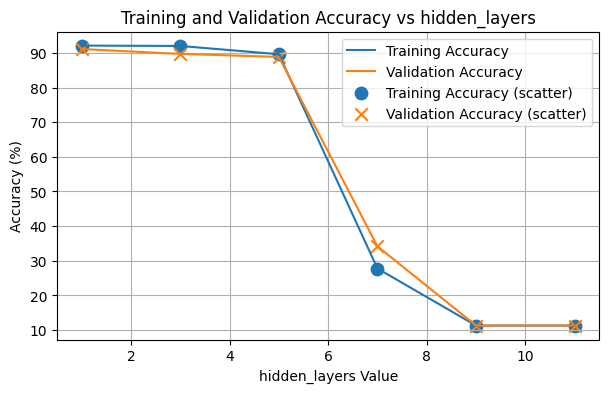

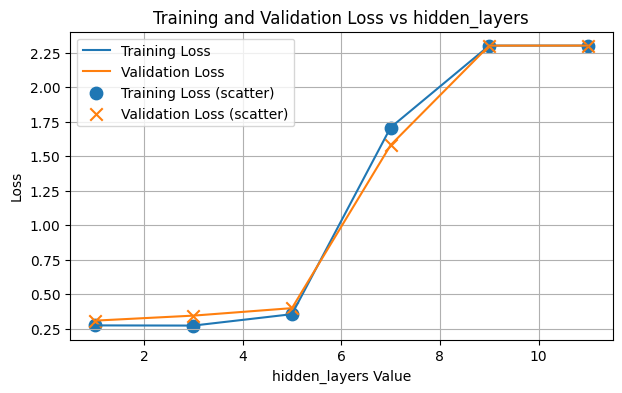

--------------------------------------------- Accuracy and Loss for hidden_size -------------------------------------------- 


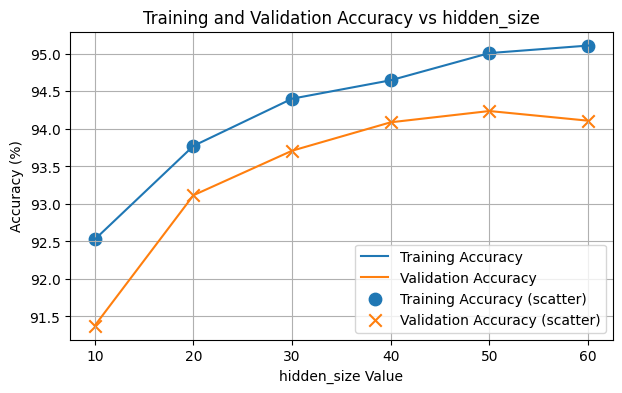

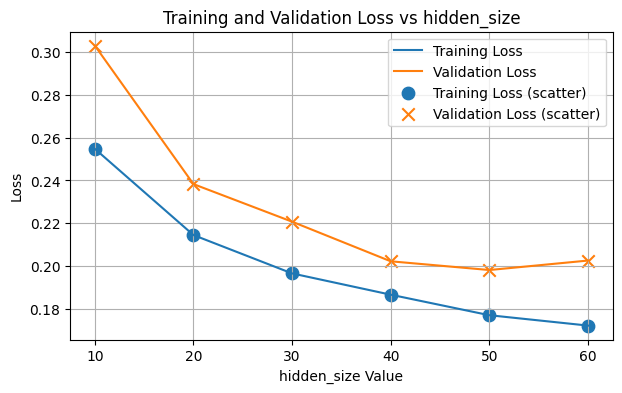

--------------------------------------------- Accuracy and Loss for batch_size -------------------------------------------- 


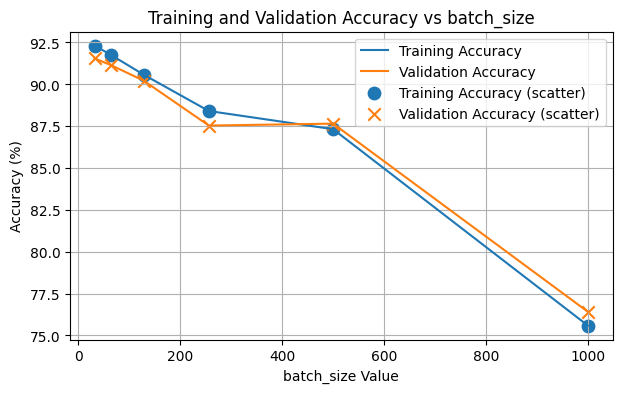

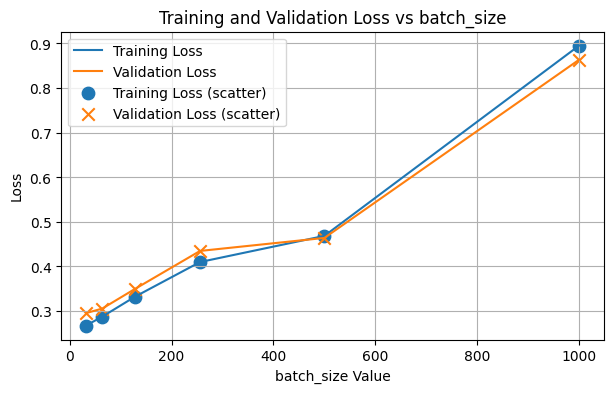

--------------------------------------------- Accuracy and Loss for learning_rate -------------------------------------------- 


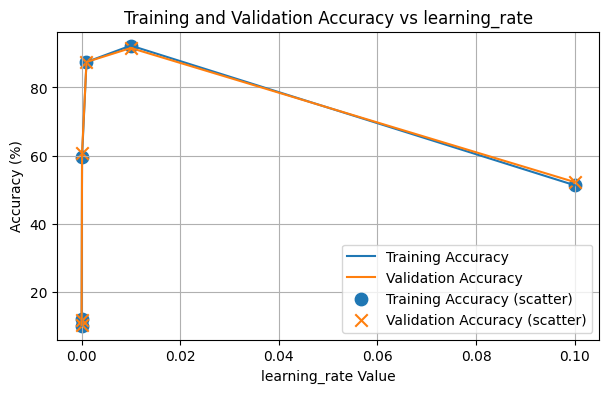

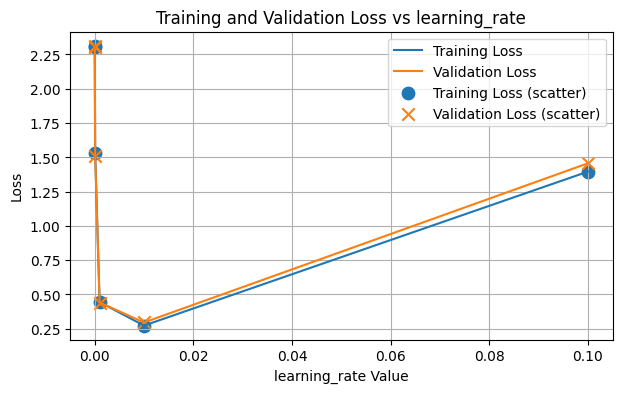

--------------------------------------------- Confusion Matrix for learning_rate -------------------------------------------- 


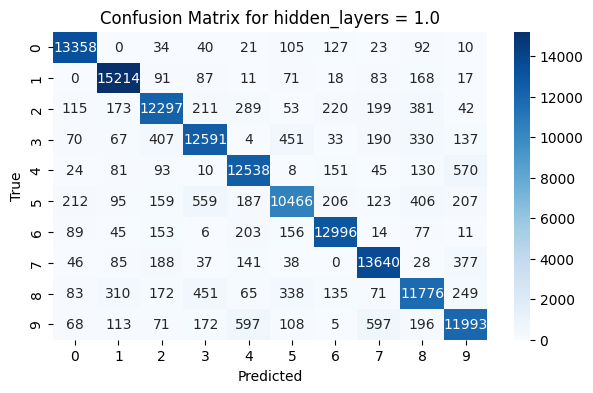

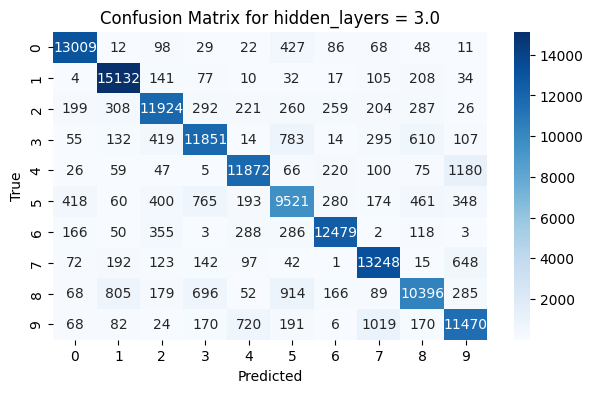

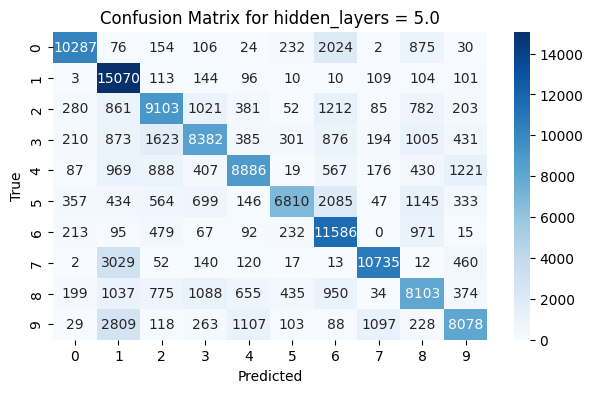

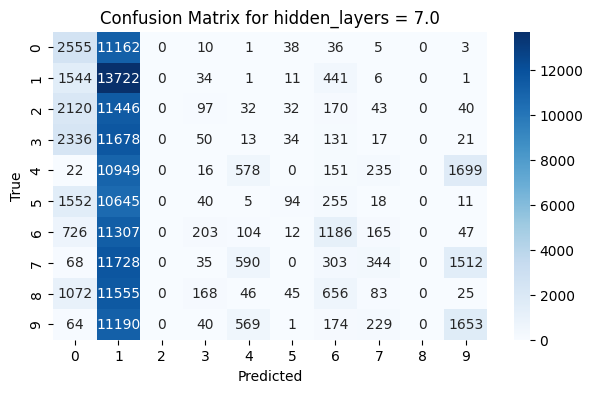

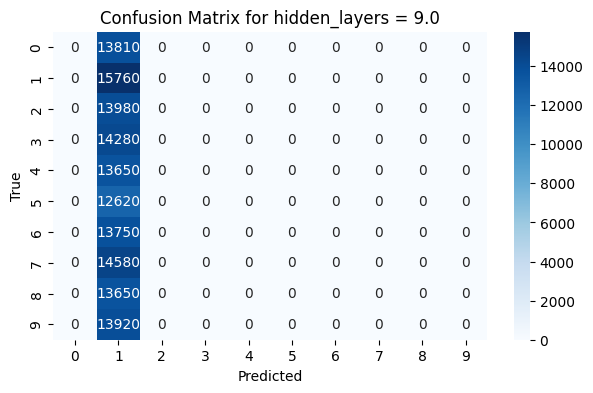

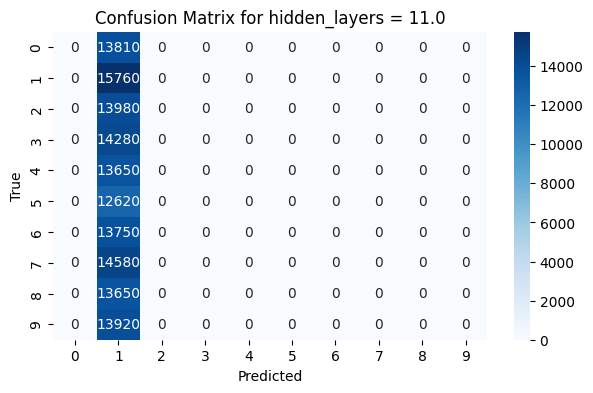

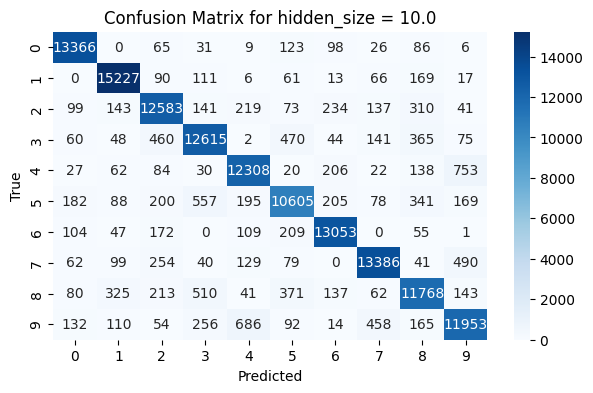

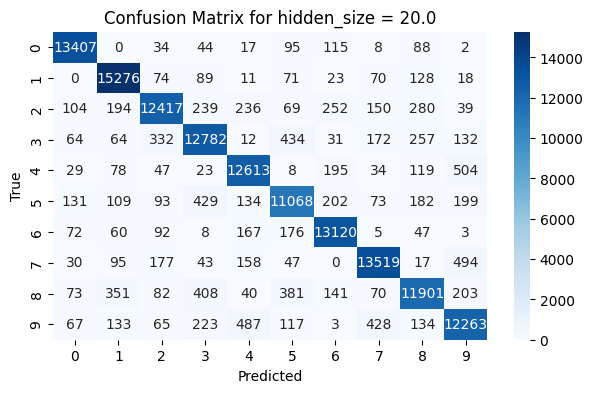

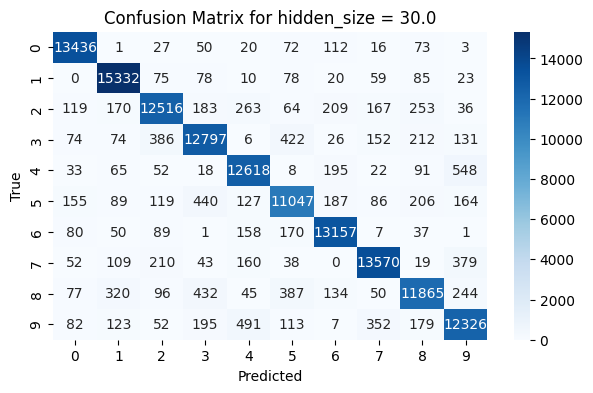

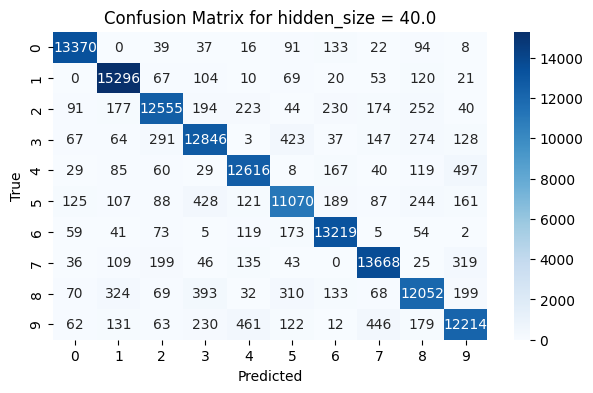

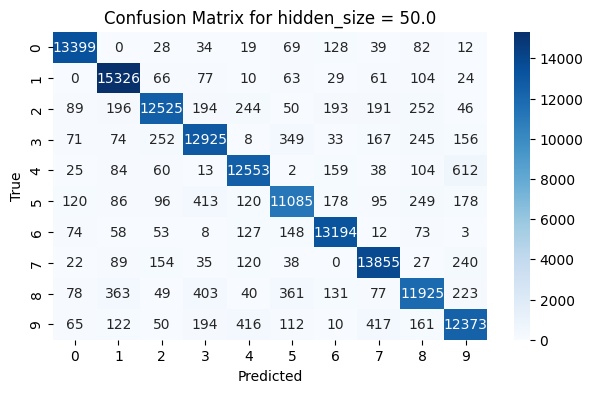

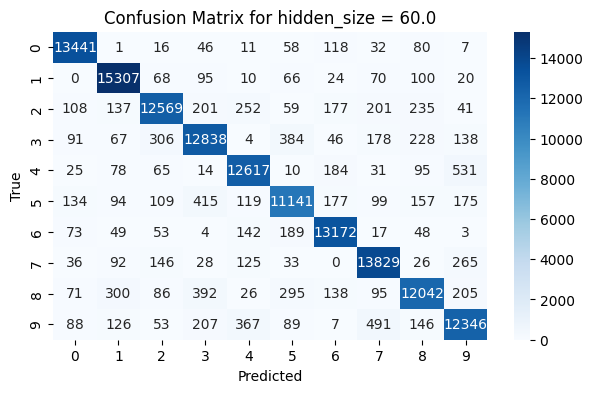

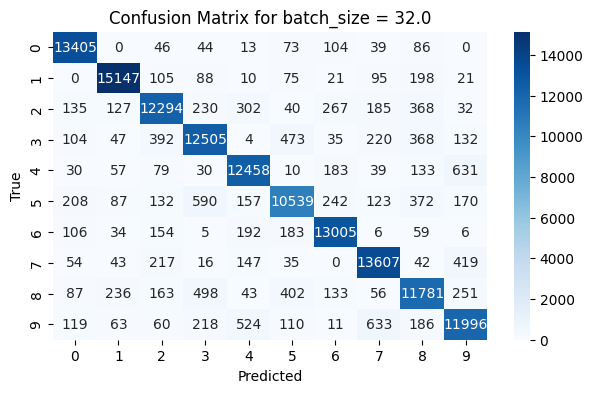

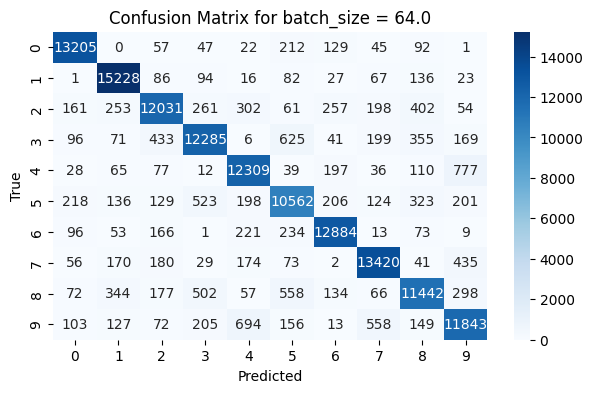

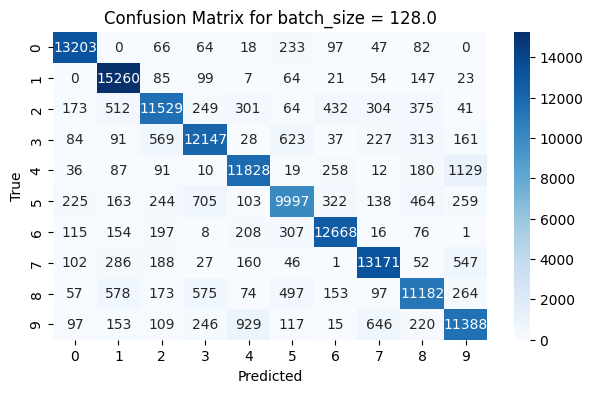

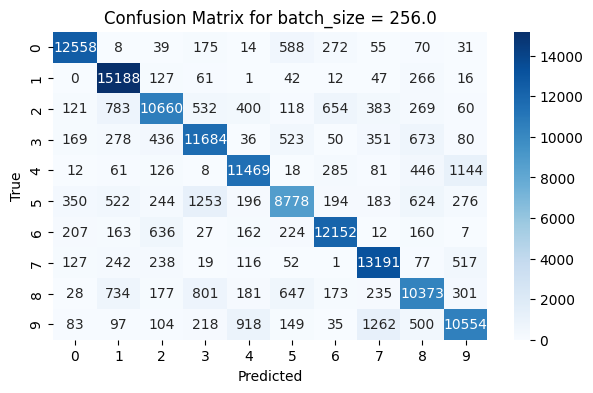

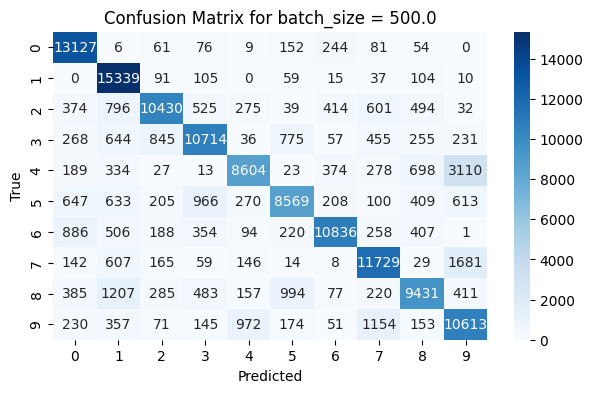

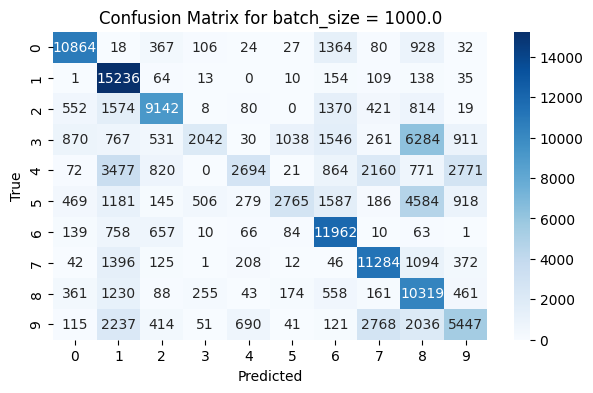

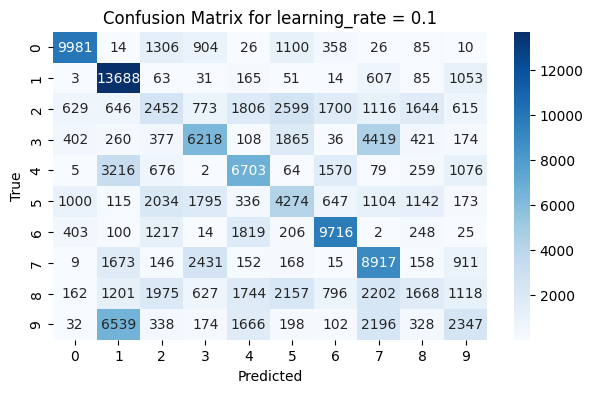

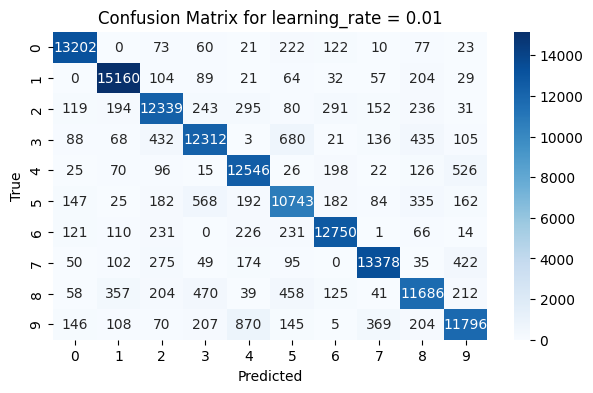

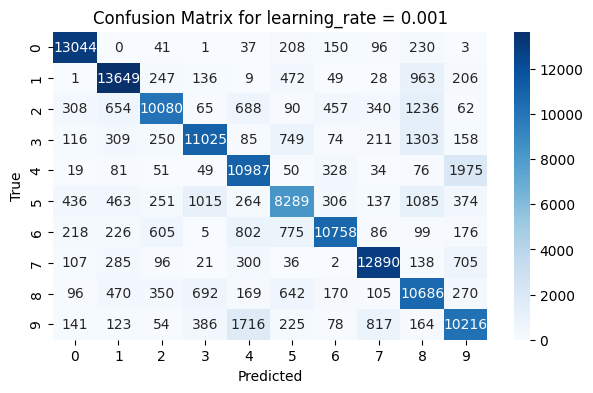

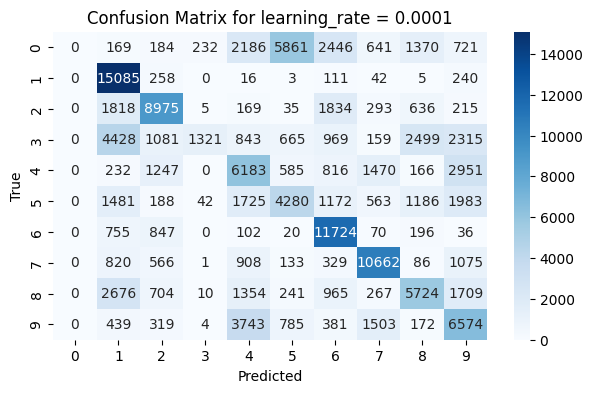

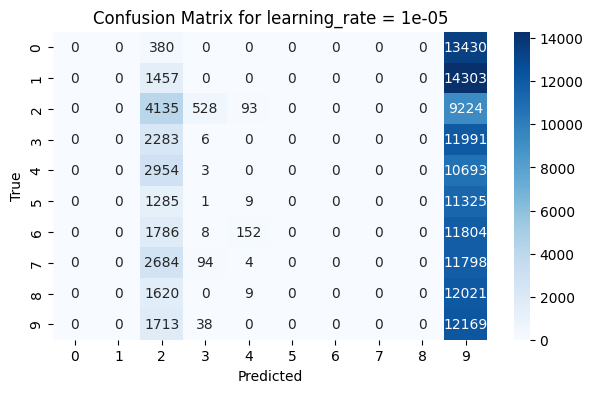

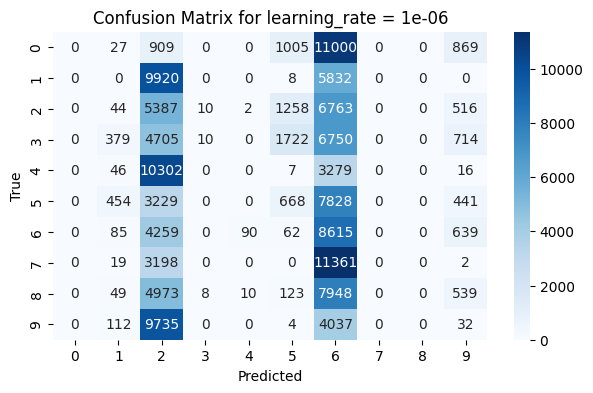

In [57]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Plot Training & Validation Accuracy and Loss for each parameter separately
unique_params = df["param"].unique()

for param in unique_params:
    # Filter the DataFrame for the current parameter
    subset = df[df["param"] == param]

    print(f"--------------------------------------------- Accuracy and Loss for {param} -------------------------------------------- ")

    # Plot Training and Validation Accuracy on the same graph
    plt.figure(figsize=(7, 4))
    plt.plot(subset["value"], subset["train_accuracy"], linestyle='-', label="Training Accuracy")
    plt.plot(subset["value"], subset["val_accuracy"], linestyle='-', label="Validation Accuracy")
    plt.scatter(subset["value"], subset["train_accuracy"], marker='o', s=80, label="Training Accuracy (scatter)")
    plt.scatter(subset["value"], subset["val_accuracy"], marker='x', s=80, label="Validation Accuracy (scatter)")
    plt.title(f"Training and Validation Accuracy vs {param}")
    plt.xlabel(f"{param} Value")
    plt.ylabel("Accuracy (%)")
    plt.grid()
    plt.legend()
    plt.show()

    # Plot Training and Validation Loss on the same graph
    plt.figure(figsize=(7, 4))
    plt.plot(subset["value"], subset["train_loss"], linestyle='-', label="Training Loss")
    plt.plot(subset["value"], subset["val_loss"], linestyle='-', label="Validation Loss")
    plt.scatter(subset["value"], subset["train_loss"], marker='o', s=80, label="Training Loss (scatter)")
    plt.scatter(subset["value"], subset["val_loss"], marker='x', s=80, label="Validation Loss (scatter)")
    plt.title(f"Training and Validation Loss vs {param}")
    plt.xlabel(f"{param} Value")
    plt.ylabel("Loss")
    plt.grid()
    plt.legend()
    plt.show()

print(f"--------------------------------------------- Confusion Matrix for {param} -------------------------------------------- ")

# Plot confusion matrix for each trained model
def plot_confusion_matrix(y_true, y_pred, param, value):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
    plt.title(f'Confusion Matrix for {param} = {value}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Generate confusion matrices for each parameter and value
for idx, row in df.iterrows():
    plot_confusion_matrix(row["y_true"], row["y_pred"], row["param"], row["value"])


 now we inspect the pool for the combination of parameters with the best accuracy, retrain the model using these parameters and finally verify on the test set.

In [51]:
# 1. Select the best parameters based on validation accuracy
def select_best_params(results):
    best_result = max(results, key=lambda x: x["val_accuracy"])  # Find the best validation accuracy
    best_params = best_result["param"], best_result["value"]  # Extract the parameter name and value
    print(f"Best Parameter: {best_params[0]} = {best_params[1]}")
    return best_params, best_result

best_params, best_result = select_best_params(results)
print(best_params)

# 2. Train the final model using the best parameters on combined train + validation data
combined_train_data = torch.utils.data.ConcatDataset([train_data, val_data])
combined_train_loader = DataLoader(combined_train_data, batch_size=default_params["batch_size"], shuffle=True)

# Reinitialize the model with the best hyperparameters
if best_params[0] == "hidden_layers":
    default_params["hidden_layers"] = best_params[1]
elif best_params[0] == "hidden_size":
    default_params["hidden_size"] = best_params[1]  # Use the value, not the name
elif best_params[0] == "batch_size":
    default_params["batch_size"] = best_params[1]  # Correct this to use the value
elif best_params[0] == "learning_rate":
    default_params["learning_rate"] = best_params[1]  # Correct this to use the value

# Create and train the model
final_model = Neural_Network_1_hidden_layer(
    input_size=28*28, 
    hidden_size=default_params["hidden_size"], 
    num_classes=10
).to(device)

final_optimizer = optim.SGD(final_model.parameters(), lr=default_params["learning_rate"])
final_criterion = nn.CrossEntropyLoss()

# Train the model on combined data
_, _, train_accs,val_accs,_ ,_ = train_model(
    final_model, combined_train_loader, val_loader, final_criterion, final_optimizer, num_epochs=10
)


Best Parameter: hidden_size = 50
('hidden_size', 50)
Epoch [1/10], Train Loss: 0.6035, Train Accuracy: 84.06%, Validation Loss: 0.3581, Validation Accuracy: 90.04%
Epoch [2/10], Train Loss: 0.3235, Train Accuracy: 90.75%, Validation Loss: 0.2958, Validation Accuracy: 91.68%
Epoch [3/10], Train Loss: 0.2814, Train Accuracy: 91.88%, Validation Loss: 0.2654, Validation Accuracy: 92.42%
Epoch [4/10], Train Loss: 0.2513, Train Accuracy: 92.76%, Validation Loss: 0.2376, Validation Accuracy: 93.04%
Epoch [5/10], Train Loss: 0.2249, Train Accuracy: 93.56%, Validation Loss: 0.2168, Validation Accuracy: 93.59%
Epoch [6/10], Train Loss: 0.2036, Train Accuracy: 94.16%, Validation Loss: 0.1931, Validation Accuracy: 94.51%
Epoch [7/10], Train Loss: 0.1862, Train Accuracy: 94.62%, Validation Loss: 0.1788, Validation Accuracy: 95.00%
Epoch [8/10], Train Loss: 0.1713, Train Accuracy: 95.07%, Validation Loss: 0.1622, Validation Accuracy: 95.44%
Epoch [9/10], Train Loss: 0.1590, Train Accuracy: 95.46%, V

In [44]:
def evaluate_on_test_set(model, test_loader):
    model.eval()  # Set model to evaluation mode
    correct_test = 0
    total_test = 0
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    test_acc = 100 * correct_test / total_test
    print(f'Test Accuracy: {test_acc:.2f}%')

    return y_true, y_pred, test_acc

In [46]:
# Evaluate on the test set
y_true, y_pred, test_acc = evaluate_on_test_set(final_model, test_loader)

Test Accuracy: 94.98%


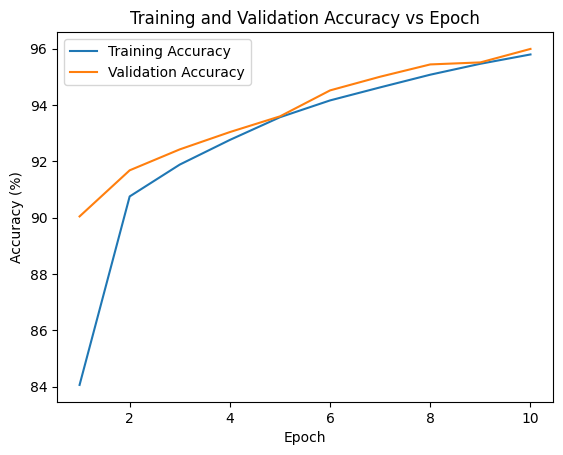

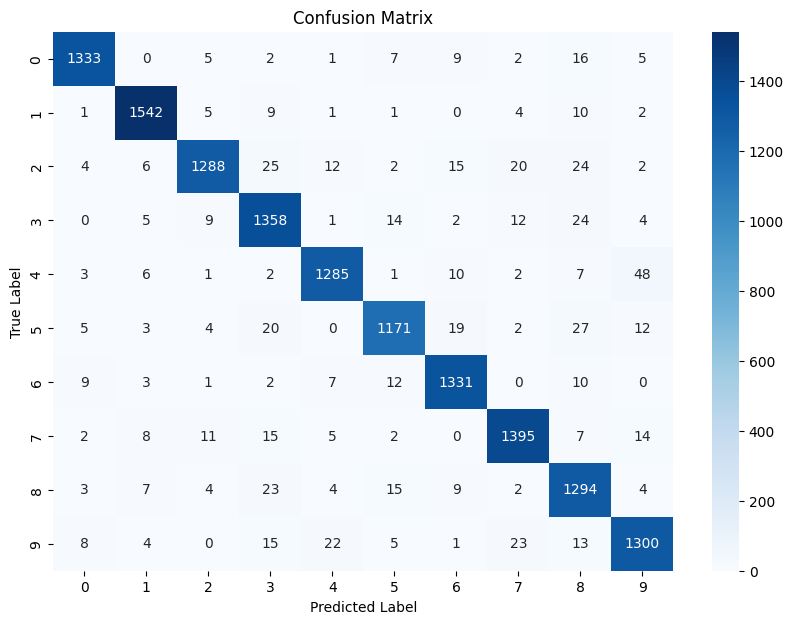

Test Accuracy: 94.98%


In [52]:
# Plot the accuracies for training and validation
epochs = list(range(1, 11)) 
plt.plot(epochs,train_accs, label="Training Accuracy")
plt.plot(epochs,val_accs, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training and Validation Accuracy vs Epoch")
plt.legend()
plt.show()

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred)

# Optionally, print the test accuracy
print(f"Test Accuracy: {test_acc:.2f}%")

## Bonus (CNN)
 we will adjust the previous code and repeat the process for convoltional Neural Networks and study their features closely.

In [65]:

# Load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True) #this structure contains data and labels
test_dataset = datasets.MNIST(root='./data', train=False)

#combine the datasets
combined_dataset=ConcatDataset([train_dataset,test_dataset])

#extract labels
train_labels=train_dataset.targets
test_labels=test_dataset.targets

# Combine labels from both train and test datasets
all_labels = torch.cat((train_labels, test_labels), dim=0)

#split into 60-40 
train_idx, temp_idx = train_test_split(
    range(len(combined_dataset)), test_size=0.4, stratify=all_labels, random_state=42) # stratify 3lshan not to get skewed data


#split again 20-20
# Split temp (40%) into validation (20%) and test (20%)
val_idx, test_idx = train_test_split(
    temp_idx, test_size=0.5, stratify=all_labels[temp_idx], random_state=42) # returns indices 


# Create Subset objects for train, validation, and test sets
train_data = Subset(combined_dataset, train_idx)
val_data = Subset(combined_dataset, val_idx)
test_data = Subset(combined_dataset, test_idx) 


##recreate dataset w inheirt combatible structure with data loader
# Create DataLoader objects
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Print split sizes
print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")
print("Data preparation complete!")



Training set size: 42000
Validation set size: 14000
Test set size: 14000
Data preparation complete!


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Default hyperparameters
default_params_cnn = {
    "hidden_layers": 5,  # Number of convolutional layers
    "hidden_size": 10,   # Number of filters per layer
    "batch_size": 32,    # Batch size
    "learning_rate": 0.01,
    "dropout_prob": 0.5  # Dropout probability
}

# Hyperparameter ranges for tuning
param_ranges_cnn = {
    "hidden_layers": [5, 7, 9],
    "hidden_size": [30, 50, 70],
    "batch_size": [128, 256, 512],
    "learning_rate": [0.01, 0.001, 0.0001],
    "dropout_prob": [0.25, 0.5, 0.75]
}

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data preparation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = datasets.MNIST(root="data", train=True, download=True, transform=transform)
val_data = datasets.MNIST(root="data", train=False, download=True, transform=transform)


class ConvNeuralNetwork(nn.Module):
    def __init__(self, input_channels, hidden_layers, hidden_size, num_classes, dropout_prob):
        super(ConvNeuralNetwork, self).__init__()

        layers = []

        # First convolutional layer
        layers.append(nn.Conv2d(input_channels, hidden_size, kernel_size=3, padding=1))  # 3x3 kernel
        layers.append(nn.ReLU())
        layers.append(nn.LayerNorm([hidden_size, 28, 28]))
        layers.append(nn.Dropout(dropout_prob))

        # Additional convolutional layers
        for i in range(1, hidden_layers):
            layers.append(nn.Conv2d(hidden_size, hidden_size, kernel_size=3, padding=1))
            layers.append(nn.ReLU())
            layers.append(nn.LayerNorm([hidden_size, 28, 28]))
            layers.append(nn.Dropout(dropout_prob))

        # Pooling layer
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))  # Reduces dimensions to 14x14

        # Flatten layer for the fully connected layer
        self.flatten = nn.Flatten()

        # Fully connected layer
        fc_input_size = hidden_size * 14 * 14  # After pooling
        self.fc = nn.Linear(fc_input_size, num_classes)

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        x = self.network(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x


def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        correct, total, train_loss = 0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(correct / total)

        # Validation phase
        model.eval()
        correct, total, val_loss = 0, 0, 0
        y_true, y_pred = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(correct / total)

        print(f"Epoch {epoch + 1}/{num_epochs} - "
              f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f} - "
              f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies, y_true, y_pred


def tune_hyperparameters(default_params, param_ranges, num_epochs=10):
    results = []

    # Iterate over each parameter
    for param, values in param_ranges.items():
        for value in values:
            # Update the parameter value
            params = default_params.copy()
            params[param] = value

            # Update DataLoader if batch_size changes
            batch_size = params["batch_size"]
            train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

            # Build the model
            model = ConvNeuralNetwork(
                input_channels=1,  # MNIST has 1 channel
                hidden_layers=params["hidden_layers"],
                hidden_size=params["hidden_size"],
                num_classes=10,
                dropout_prob=params["dropout_prob"]
            ).to(device)

            # Define optimizer with new learning rate
            optimizer = optim.Adam(model.parameters(), lr=params["learning_rate"])
            criterion = nn.CrossEntropyLoss()

            # Train the model
            train_losses, val_losses, train_accuracies, val_accuracies, y_true, y_pred = train_model(
                model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs
            )

            # Record results
            results.append({
                "param": param,
                "value": value,
                "train_accuracy": train_accuracies[-1],
                "val_accuracy": val_accuracies[-1],
                "train_loss": train_losses[-1],
                "val_loss": val_losses[-1],
                "y_true": y_true,
                "y_pred": y_pred
            })

            print(f"Completed training for {param} = {value}")

    return results


# Example usage
results = tune_hyperparameters(default_params_cnn, param_ranges_cnn, num_epochs=5)


Epoch 1/5 - Train Loss: 0.6286, Train Accuracy: 0.8488 - Val Loss: 0.3645, Val Accuracy: 0.8917
Epoch 2/5 - Train Loss: 0.2694, Train Accuracy: 0.9290 - Val Loss: 0.2912, Val Accuracy: 0.9140
Epoch 3/5 - Train Loss: 0.2581, Train Accuracy: 0.9356 - Val Loss: 1.0703, Val Accuracy: 0.7722
Epoch 4/5 - Train Loss: 0.2719, Train Accuracy: 0.9366 - Val Loss: 0.6632, Val Accuracy: 0.8681
Epoch 5/5 - Train Loss: 0.2767, Train Accuracy: 0.9394 - Val Loss: 0.6576, Val Accuracy: 0.8632
Completed training for hidden_layers = 5
Epoch 1/5 - Train Loss: 0.5572, Train Accuracy: 0.8637 - Val Loss: 1.8260, Val Accuracy: 0.4912
Epoch 2/5 - Train Loss: 0.2922, Train Accuracy: 0.9168 - Val Loss: 1.0553, Val Accuracy: 0.7176
Epoch 3/5 - Train Loss: 0.2916, Train Accuracy: 0.9214 - Val Loss: 0.4345, Val Accuracy: 0.8793
Epoch 4/5 - Train Loss: 0.2892, Train Accuracy: 0.9253 - Val Loss: 0.3959, Val Accuracy: 0.9011
Epoch 5/5 - Train Loss: 0.2826, Train Accuracy: 0.9292 - Val Loss: 0.2874, Val Accuracy: 0.9317

In [ ]:

# Convert the results list to a DataFrame
df = pd.DataFrame(results)

# Inspect the columns to ensure they match expected names
print("Columns in DataFrame:", df.columns)

# Verify sample rows to confirm data integrity
print(df.head())


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Plot Training & Validation Accuracy and Loss for each parameter separately
unique_params = df["param"].unique()

for param in unique_params:
    # Filter the DataFrame for the current parameter
    subset = df[df["param"] == param]

    print(f"--------------------------------------------- Accuracy and Loss for {param} -------------------------------------------- ")

    # Plot Training and Validation Accuracy on the same graph
    plt.figure(figsize=(7, 4))
    plt.plot(subset["value"], subset["train_accuracy"], linestyle='-', label="Training Accuracy")
    plt.plot(subset["value"], subset["val_accuracy"], linestyle='-', label="Validation Accuracy")
    plt.scatter(subset["value"], subset["train_accuracy"], marker='o', s=80, label="Training Accuracy (scatter)")
    plt.scatter(subset["value"], subset["val_accuracy"], marker='x', s=80, label="Validation Accuracy (scatter)")
    plt.title(f"Training and Validation Accuracy vs {param}")
    plt.xlabel(f"{param} Value")
    plt.ylabel("Accuracy (%)")
    plt.grid()
    plt.legend()
    plt.show()

    # Plot Training and Validation Loss on the same graph
    plt.figure(figsize=(7, 4))
    plt.plot(subset["value"], subset["train_loss"], linestyle='-', label="Training Loss")
    plt.plot(subset["value"], subset["val_loss"], linestyle='-', label="Validation Loss")
    plt.scatter(subset["value"], subset["train_loss"], marker='o', s=80, label="Training Loss (scatter)")
    plt.scatter(subset["value"], subset["val_loss"], marker='x', s=80, label="Validation Loss (scatter)")
    plt.title(f"Training and Validation Loss vs {param}")
    plt.xlabel(f"{param} Value")
    plt.ylabel("Loss")
    plt.grid()
    plt.legend()
    plt.show()

print(f"--------------------------------------------- Confusion Matrix for {param} -------------------------------------------- ")

# Plot confusion matrix for each trained model
def plot_confusion_matrix(y_true, y_pred, param, value):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
    plt.title(f'Confusion Matrix for {param} = {value}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Generate confusion matrices for each parameter and value
for idx, row in df.iterrows():
    plot_confusion_matrix(row["y_true"], row["y_pred"], row["param"], row["value"])


In [ ]:


best_params, best_result = select_best_params(results_cnn)
print(best_params)

# 2. Train the final model using the best parameters on combined train + validation data
combined_train_data = torch.utils.data.ConcatDataset([train_data, val_data])
combined_train_loader = DataLoader(combined_train_data, batch_size=default_params["batch_size"], shuffle=True)

# Reinitialize the model with the best hyperparameters
if best_params[0] == "hidden_layers":
    default_params_cnn["hidden_layers"] = best_params[1]
elif best_params[0] == "hidden_size":
    default_params_cnn["hidden_size"] = best_params[1]  # Use the value, not the name
elif best_params[0] == "batch_size":
    default_params_cnn["batch_size"] = best_params[1]  # Correct this to use the value
elif best_params[0] == "learning_rate":
    default_params_cnn["learning_rate"] = best_params[1]  # Correct this to use the value
elif best_params[0] == "dropout_prob":
    default_params_cnn["dropout_prob"] = best_params[1]

# Create and train the model
final_model = ConvNeuralNetwork(
    input_size=28*28, 
    hidden_size=default_params_cnn["hidden_size"], 
    num_classes=10,
    dropout_prob=default_params_cnn["dropout_prob"]
).to(device)

final_optimizer = optim.Adam(final_model.parameters(), lr=default_params_cnn["learning_rate"])
final_criterion = nn.CrossEntropyLoss()

# Train the model on combined data
_, _, train_accs,val_accs,_ ,_ = train_model(
    final_model, combined_train_loader, val_loader, final_criterion, final_optimizer, num_epochs=10
)


In [ ]:
# Evaluate on the test set
y_true, y_pred, test_acc = evaluate_on_test_set(final_model, test_loader)

In [ ]:
# Plot the accuracies for training and validation
epochs = list(range(1, 11)) 
plt.plot(epochs,train_accs, label="Training Accuracy")
plt.plot(epochs,val_accs, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training and Validation Accuracy vs Epoch")
plt.legend()
plt.show()

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred)

# Optionally, print the test accuracy
print(f"Test Accuracy: {test_acc:.2f}%")